<a href="https://colab.research.google.com/github/pollyjuice74/Error-Bit-Decoding/blob/main/NeuralDemapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Layer Dense Neural Network Decoder for End-to-End System

---

This notebook implements a 3 layer, dense neural network decoder and a end to end system using NVlabs Sionna library.

The purpose is to serve as an example and practice, not for practical use.

The NN's performance is then compared to a standard Decoder.

---

In [ ]:
# general imports
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

# load required Sionna components
!pip install sionna
import sionna as sn
from sionna.fec.utils import load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder

%load_ext autoreload
%autoreload 2
!git clone https://github.com/NVlabs/gnn-decoder.git
%cd gnn-decoder
from gnn import * # load GNN functions
from wbp import * # load weighted BP functions

from google.colab import drive
drive.mount('/content/drive')


In [2]:
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 1
Only GPU number 0 used.


---

Implementation of NeuralDemapper, E2ESystem and Baseline decoder system.

---

In [3]:
NUM_BITS_PER_SYMBOL = 6
batch_size = 5
ebno_db = 17.0
EBN0_DB_MIN = 10.0
EBN0_DB_MAX = 20.0

class NeuralDemapper(Model):
  def __init__(self):
    super().__init__()
    self.dense1 = Dense(64, 'relu')
    self.dense2 = Dense(64, 'relu')
    self.dense3 = Dense(NUM_BITS_PER_SYMBOL, None)

  def call(self, y):
     # y : complex-valued with shape [batch size, block length]
     nn_input = tf.stack([tf.math.real(y), tf.math.imag(y)], axis=-1)
     z = self.dense1(nn_input)
     z = self.dense2(z)
     z = self.dense3(z)
     llr = tf.reshape(z, [tf.shape(y)[0], -1])
     return llr


class E2ESystem(Model):
  def __init__(self, training):
    super().__init__()

    self._bsrc = sn.utils.BinarySource()
    self._channel = sn.channel.AWGN()

    self._constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL, trainable=True)
    self._mapper = sn.mapping.Mapper(constellation=self._constellation)
    self._demapper = NeuralDemapper()
    self._bce = tf.keras.losses.BinaryCrossentropy()

    self.training = training # bool

  @tf.function(jit_compile=True)
  def __call__(self, batch_size, ebno_db):
    no = sn.utils.ebnodb2no(ebno_db,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0)
    bits = self._bsrc([batch_size, 240]) # Blocklength set to 240 bits
    x = self._mapper(bits)
    y = self._channel([x, no])
    llr = self._demapper(y)
    if self.training:
      return self._bce(bits, llr) # Loss
    else:
      return bits, llr


class Baseline(Model): # Inherits from Keras Model

  def __init__(self):

      super().__init__() # Must call the Keras model initializer

      self.constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
      self.mapper = sn.mapping.Mapper(constellation=self.constellation)
      self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
      self.binary_source = sn.utils.BinarySource()
      self.awgn_channel = sn.channel.AWGN()

  @tf.function # Enable graph execution to speed things up
  def __call__(self, batch_size, ebno_db):

      # no channel coding used; we set coderate=1.0
      no = sn.utils.ebnodb2no(ebno_db,
                              num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                              coderate=1.0)
      bits = self.binary_source([batch_size, 240]) # Blocklength set to 240 bits
      x = self.mapper(bits)
      y = self.awgn_channel([x, no])
      llr = self.demapper([y,no])
      return bits, llr


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     10.0 | 4.8479e-01 | 1.0000e+00 |       11635 |       24000 |          100 |         100 |         1.5 |reached target block errors
   10.526 | 4.8900e-01 | 1.0000e+00 |       11736 |       24000 |          100 |         100 |         0.4 |reached target block errors
   11.053 | 4.8762e-01 | 1.0000e+00 |       11703 |       24000 |          100 |         100 |         0.3 |reached target block errors
   11.579 | 4.8942e-01 | 1.0000e+00 |       11746 |       24000 |          100 |         100 |         0.4 |reached target block errors
   12.105 | 4.8662e-01 | 1.0000e+00 |       11679 |       24000 |          100 |         100 |         0.4 |reached target block errors
   12.632 | 4.9321e-01 | 1.0000e+00 |       11837 |       24000 |

(<tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([2.58750000e-02, 2.07936508e-02, 1.62698413e-02, 1.21590909e-02,
        9.23913043e-03, 6.37820513e-03, 3.99509804e-03, 2.97916667e-03,
        1.85792350e-03, 1.16255144e-03, 6.58333333e-04, 3.00000000e-04,
        1.83333333e-04, 5.83333333e-05, 1.66666667e-05, 2.50000000e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([1.        , 0.99047619, 0.96190476, 0.92727273, 0.87826087,
        0.76923077, 0.6       , 0.505     , 0.33770492, 0.24938272,
        0.152     , 0.07      , 0.044     , 0.014     , 0.004     ,
        0.006     , 0.        , 0.        , 0.        , 0.        ])>)

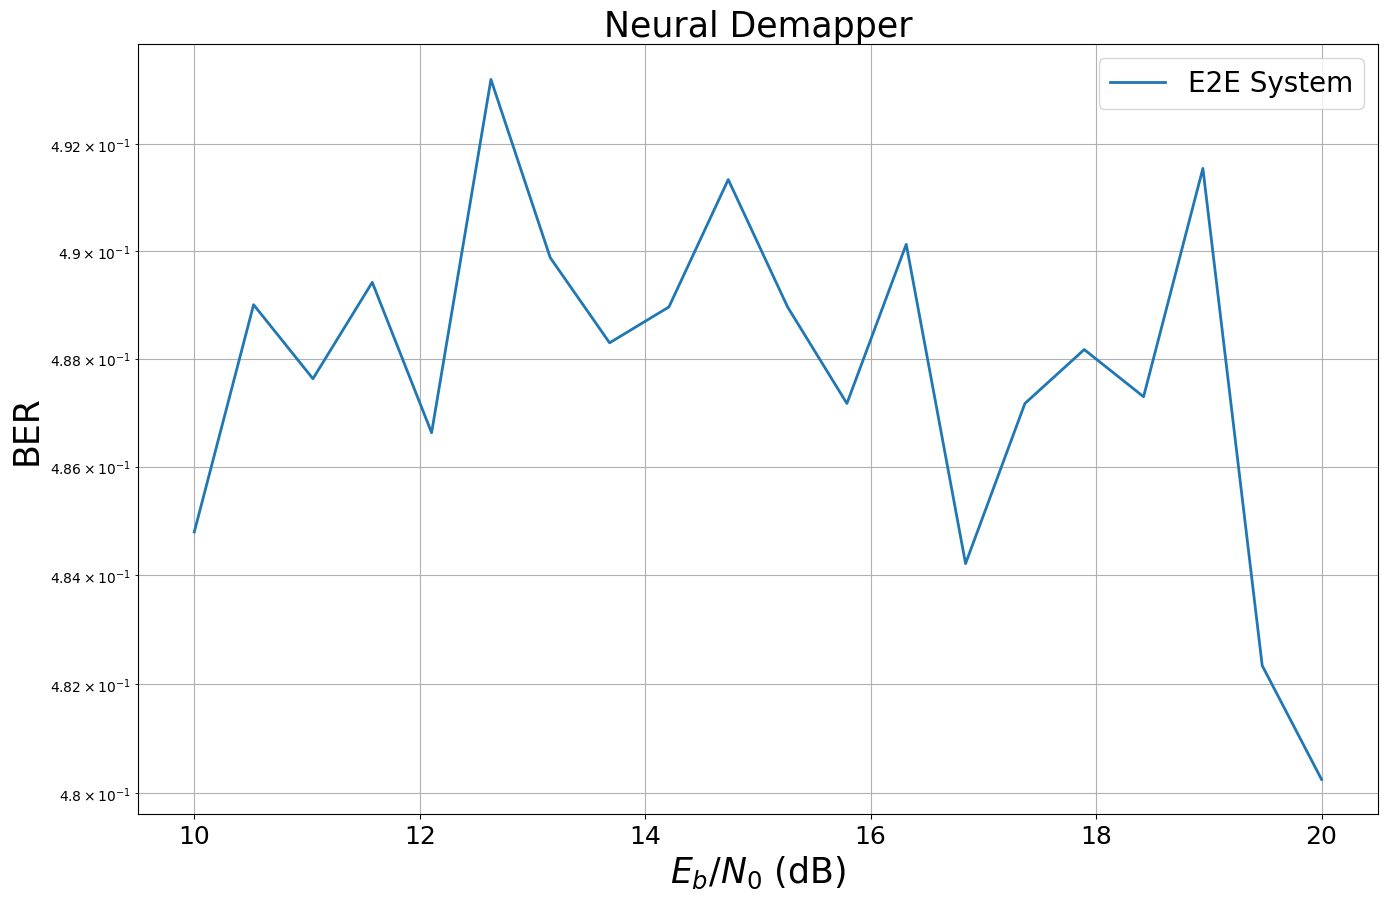

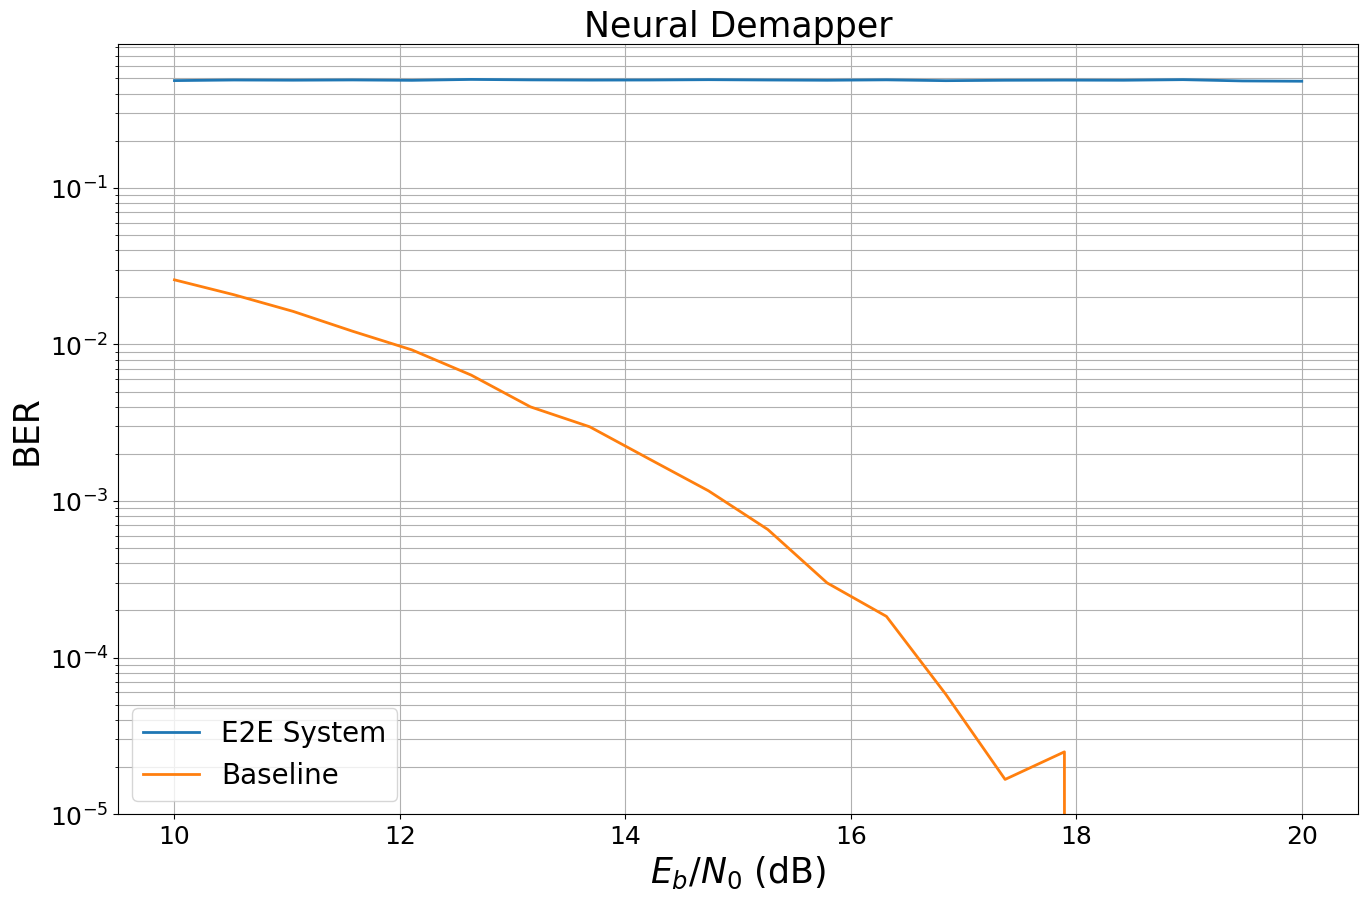

In [24]:
baseline = Baseline()
model = E2ESystem(False)

ber_plots = sn.utils.PlotBER("Neural Demapper")

# Plotting and comparing performance
ber_plots.simulate(model,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                   batch_size=batch_size,
                   num_target_block_errors=100,
                   legend='E2E System',
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True)
ber_plots.simulate(baseline,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=100,
                   legend='Baseline',
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True)

---

Train loop

---

In [ ]:
ITERS = 1000000

tf.random.set_seed(1)

optimizer = tf.keras.optimizers.Adam()

# Train mode
if not model:
  model = E2ESystem(training=True)
elif not model.training:
  model.training = True

# Load weights
model.load_weights('/content/drive/MyDrive/weights/dense_3_layers')

# Train Loop
for i in range(ITERS):
  with tf.GradientTape() as tape:
    loss = model(batch_size, 15.0)

  grads = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  if i % 1000 == 0:
    print(f"{i}/{ITERS} Loss: {loss: .4f}")

# Save the weights to a file
model.save_weights('/content/drive/MyDrive/weights/dense_3_layers')


0/1000000 Loss:  0.1849
1000/1000000 Loss:  0.0082
2000/1000000 Loss:  0.0045
3000/1000000 Loss:  0.0055
4000/1000000 Loss:  0.0029
5000/1000000 Loss:  0.0056
6000/1000000 Loss:  0.0019
7000/1000000 Loss:  0.3327
8000/1000000 Loss:  0.0053
9000/1000000 Loss:  0.0026
10000/1000000 Loss:  0.0025
11000/1000000 Loss:  0.0017
12000/1000000 Loss:  0.0017
13000/1000000 Loss:  0.0147
14000/1000000 Loss:  0.0025
15000/1000000 Loss:  0.0592
16000/1000000 Loss:  0.0038
17000/1000000 Loss:  0.0057
18000/1000000 Loss:  0.0084
19000/1000000 Loss:  0.0029
20000/1000000 Loss:  0.0050
21000/1000000 Loss:  0.0327
22000/1000000 Loss:  0.0179
23000/1000000 Loss:  0.0017
24000/1000000 Loss:  0.0309
25000/1000000 Loss:  0.1571
26000/1000000 Loss:  0.0022
27000/1000000 Loss:  0.0164
28000/1000000 Loss:  0.0161
29000/1000000 Loss:  0.0024
30000/1000000 Loss:  0.0025
31000/1000000 Loss:  0.0035
32000/1000000 Loss:  0.0015
33000/1000000 Loss:  0.0176
34000/1000000 Loss:  0.0173
35000/1000000 Loss:  0.0027
36000